# Setup

Dependencies:
- System: python3; swig (required for gymnasium[box2d]); ffmpeg, xvfb (for rendering videos)
- Python: jupyter, numpy, matplotlib; gymnasium[box2d] (for RL environment); jax, equinox, optax (for training neural networks); opencv-python, pyvirtualdisplay (for rendering videos)


```
sudo apt install swig ffmpeg xvfb
conda activate pora
jupyter notebook  # from the directory of this notebook
```

In [1]:
import gymnasium as gym
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt; plt.rcParams.update({'font.size': 20})
import numpy as np

import equinox as eqx
import optax

from utils.utils import display_local_video_in_notebook

import os
import cv2
from pyvirtualdisplay import Display

In [2]:
# UX options.
render_interval = 100 # Number of episodes before rendering environment simulation video
video_file_directory = "notebook_outputs"

# RL environment setup.
env = gym.make("LunarLanderContinuous-v3", render_mode="rgb_array")
env.reset(seed=0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_steps = 600

# Training parameters.
discount_factor = 0.99  # Discount factor for computing tail returns.
ema_factor = 0.99  # Exponential moving average for standardizing returns.
key = jax.random.PRNGKey(0)  # Random seed for NN initialization, action sampling. 

In [3]:
class Policy(eqx.Module):
    trunk_layers: list
    action_mean_head: eqx.Module
    action_std_head: eqx.Module
    value_head: eqx.Module

    def __init__(self, key):
        # `PRNGKey`s for initializing NN layers.
        keys = jax.random.split(key, 5)
        # Embedding layers.
        self.trunk_layers = [
            eqx.nn.Linear(state_dim, 128, key=keys[0]),
            eqx.nn.Linear(128, 128, key=keys[1]),
        ]
        # Actor's layers.
        self.action_mean_head = eqx.nn.Linear(128, action_dim, key=keys[2])
        self.action_std_head = eqx.nn.Linear(128, action_dim, key=keys[3])
        # Critic's layers.
        self.value_head = eqx.nn.Linear(128, 1, key=keys[4])

    @jax.jit
    def __call__(self, x):
        for layer in self.trunk_layers:
            x = jax.nn.relu(layer(x))
        action_mean = self.action_mean_head(x)
        action_std = jax.nn.softplus(self.action_std_head(x))
        value = self.value_head(x)[0]
        return MultivariateNormalDiag(action_mean, action_std), value


class MultivariateNormalDiag(eqx.Module):
    # Cheap knockoff of `tensorflow_probability.substrates.jax.distributions.MultivariateNormalDiag`.
    mean: jnp.array
    std: jnp.array

    @jax.jit
    def sample(self, key, shape=()):
        return self.mean + self.std * jax.random.normal(key, shape + self.mean.shape)

    @jax.jit
    def log_prob(self, value):
        return jnp.sum(jax.scipy.stats.norm.logpdf(value, self.mean, self.std), -1)


def compute_returns(rewards, discount_factor):
    tail_return = 0.
    returns = []
    for r in rewards[::-1]:
        tail_return = r + discount_factor * tail_return
        returns.append(tail_return)
    returns.reverse()
    return np.array(returns)


def train_loss_for_epsiode(policy, states, actions, returns, num_steps):
    action_distributions, values = jax.vmap(policy)(states)
    action_log_probs = action_distributions.log_prob(actions)
    advantages = returns - values
    mask = jnp.arange(max_steps) < num_steps
    actor_loss = jnp.sum(-action_log_probs * jax.lax.stop_gradient(advantages) * mask)
    critic_loss = jnp.sum(jnp.square(advantages) * mask)
    return actor_loss + critic_loss


@jax.jit
def train_step_for_episode(opt_state, policy, states, actions, returns, num_steps):
    grads = jax.grad(train_loss_for_epsiode)(policy, states, actions, returns, num_steps)
    updates, opt_state = optimizer.update(grads, opt_state)
    policy = optax.apply_updates(policy, updates)
    return opt_state, policy

In [5]:
# Create directory to store video and start display
os.makedirs(video_file_directory, exist_ok=True)
Display(visible=False, size=(1400, 900)).start()

key, policy_key = jax.random.split(key)
policy = Policy(policy_key)
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(policy)

episodic_rewards = []
episodic_reward_ema = None  # Exponential moving average of episodic rewards.
return_ema = None  # Exponential moving average of returns (i.e., critic targets).
return_emv = None  # Exponential moving variance of returns (i.e., critic targets).
for i_episode in range(3001):

    # Reset environment at the start of each episode, and clear accumulators.
    state = env.reset()[0]
    episodic_reward = 0
    states = []
    actions = []
    rewards = []

    # Sample a trajectory (episode) according to our stochastic policy/environment dynamics.
    for t in range(max_steps):
        states.append(state)
        action_distribution, _ = policy(state)
        key, sample_key = jax.random.split(key)
        action = np.array(action_distribution.sample(sample_key))  # Leave JAX to interact with gym.
        state, reward, done, _, _ = env.step(action)
        episodic_reward += reward
        actions.append(action)
        rewards.append(reward)

        # Render video at specified interval of episodes
        if i_episode % render_interval == 0:
            if t == 0:
                video_filename = f"{video_file_directory}/lunar_lander_episode_{i_episode}.mp4"
                video = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*"mp4v"), 50, (600, 400))
            video.write(env.render())
        if done:
            break

    # Compute (standardized) tail returns for the episode and update moving averages.
    episodic_rewards.append(episodic_reward)
    returns = compute_returns(rewards, discount_factor)
    if i_episode == 0:
        episodic_reward_ema = episodic_reward
        return_ema = returns.mean()
        return_emv = returns.var()
    else:
        episodic_reward_ema = 0.95 * episodic_reward_ema + (1 - 0.95) * episodic_reward
        return_ema = ema_factor * return_ema + (1 - ema_factor) * returns.mean()
        return_emv = ema_factor * (return_emv + (1 - ema_factor) * np.mean((returns - return_ema)**2))
    # Side note: for students with deep learning experience, standardizing returns
    # using moving population statistics may be reminiscent of batch normalization.
    standardized_returns = (returns - return_ema) / (np.sqrt(return_emv) + 1e-6)

    # Run a train step based on the episode's data.
    num_steps = len(states)
    # JAX prefers all arrays to be the same shape, so we pad to the batch size.
    opt_state, policy = train_step_for_episode(
        opt_state,
        policy,
        np.pad(states, ((0, max_steps - num_steps), (0, 0))),
        np.pad(actions, ((0, max_steps - num_steps), (0, 0))),
        np.pad(standardized_returns, ((0, max_steps - num_steps),)),
        num_steps,
    )

    # Periodically log results.
    if i_episode % 10 == 0:
        print(
            f"Episode {i_episode}\tLast reward: {episodic_reward:.2f}\tMoving average reward: {episodic_reward_ema:.2f}"
        )

    # Save/display video; this video corresponds to the most recently printed "Last reward".
    if i_episode % render_interval == 0:
        video.release()
        display_local_video_in_notebook(video_filename)

Episode 0	Last reward: -494.43	Moving average reward: -494.43


Episode 10	Last reward: -281.74	Moving average reward: -453.19
Episode 20	Last reward: -726.36	Moving average reward: -416.12
Episode 30	Last reward: -716.31	Moving average reward: -349.24
Episode 40	Last reward: -298.59	Moving average reward: -326.42
Episode 50	Last reward: -538.70	Moving average reward: -309.32
Episode 60	Last reward: -510.16	Moving average reward: -322.30
Episode 70	Last reward: -444.17	Moving average reward: -358.48
Episode 80	Last reward: -110.50	Moving average reward: -285.99
Episode 90	Last reward: -150.50	Moving average reward: -266.28
Episode 100	Last reward: -148.61	Moving average reward: -233.45


Episode 110	Last reward: -169.13	Moving average reward: -200.34
Episode 120	Last reward: -249.46	Moving average reward: -184.95
Episode 130	Last reward: -265.84	Moving average reward: -186.99
Episode 140	Last reward: -215.90	Moving average reward: -178.22
Episode 150	Last reward: -149.85	Moving average reward: -166.78
Episode 160	Last reward: -175.71	Moving average reward: -156.97
Episode 170	Last reward: -128.23	Moving average reward: -162.67
Episode 180	Last reward: -99.52	Moving average reward: -177.56


KeyboardInterrupt: 

Text(0.5, 1.0, 'Total Reward per Episode')

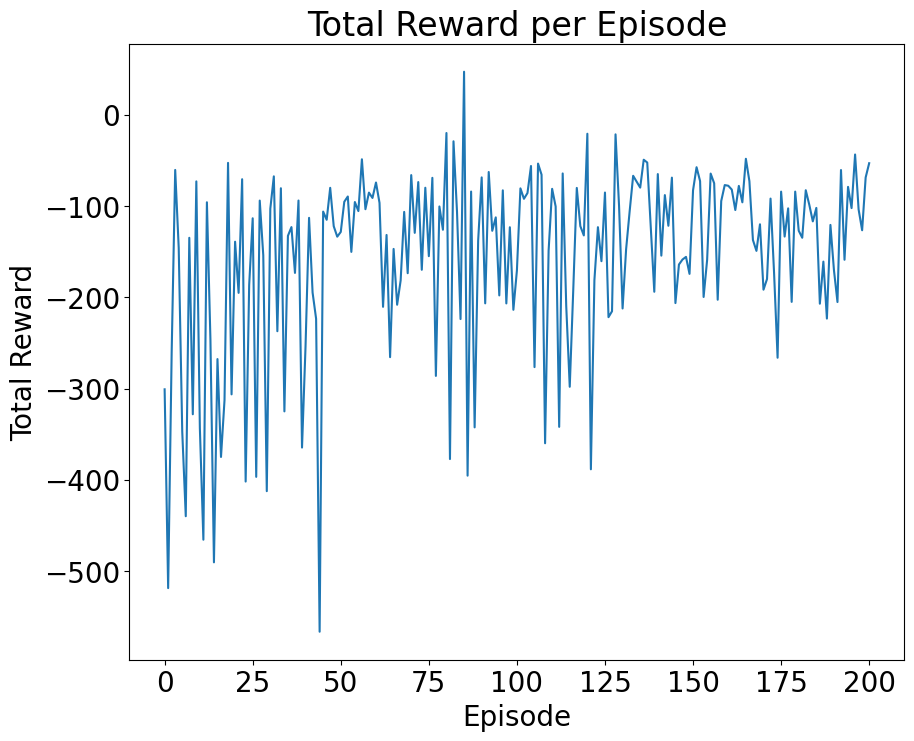

In [10]:
plt.figure(figsize=(10, 8))
plt.plot(episodic_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')